**TRAINING LSTM NN FOR TIME SERIES AND FORECASTING**
In this code we prepare the data of EOF temperature for exploring the behaviour of LSTM neural network trained on a time serie and used to do forecasting with a moving-window technique.

# *BLOCK 1. Import useful libraries*

In [ ]:
import xarray as xr # to open file '.nc'
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib as mpl # to make plots
import matplotlib.pyplot as plt # to make plots
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta # to plots dates on absissa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf # needed for data preprocessing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# *BLOCK 2. Open and read the data file*

!REMEMBER TO UPLOAD THE FILE!
It's a matrix with 30 modes of EOFs of monthly temperatures from January 1940 to december 2022 (83 years). (Matrix [n. EOF, time]).

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/dati/save_eof.nc'

Mounted at /content/drive


In [ ]:
# Read file
data = xr.open_dataset(file_path)
sst_data = data["eof"].values # extract values in an array

data.close()

In [ ]:
#data #print the data array to check that it read the data

# *BLOCK 3. Data preprocessing*
3.1.** Data normalization**: normalize the autocorrelation values between -1 and 1.

In [ ]:
def normalization(sst_data):
  min = np.min(sst_data)
  max= np.max(sst_data)
  normalized_data = 2*((sst_data-min)/(max-min)) -1
  return normalized_data

normalized_data = normalization(sst_data)

3.2. **Plot**: define a function to plot the time series for a single mode.

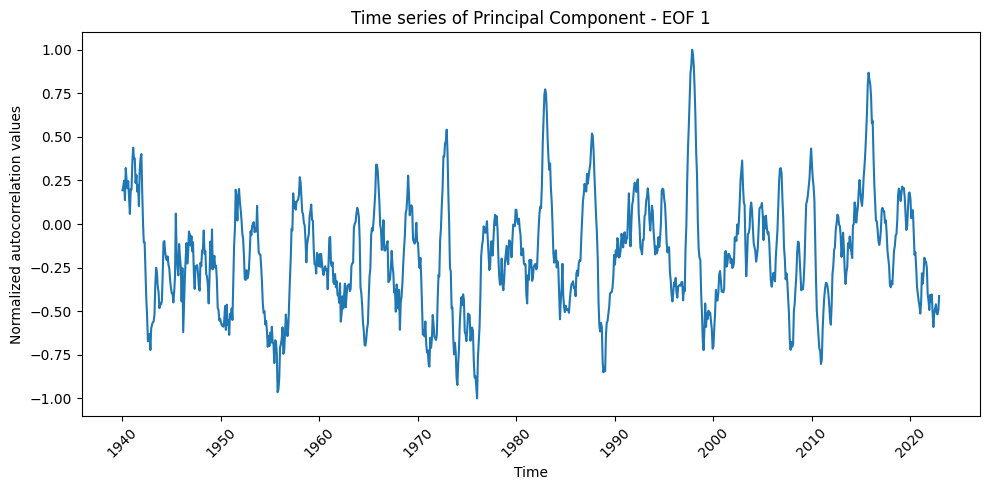

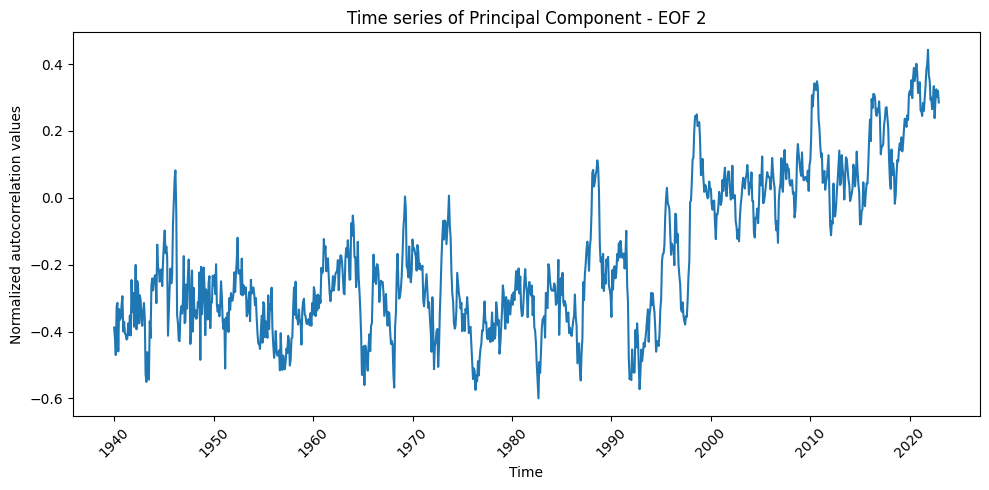

In [ ]:
# Define the time interval
start_time = pd.Timestamp('1940-01-01')
end_time = pd.Timestamp('2022-12-01')

# Create an array of time indexes for each month in the time interval
date_index = pd.date_range(start=start_time, periods=996, freq='MS')  # 'MS' beggining of the month

def plotTimeSeriesEOF(i):
    # Take the array of the matrix we are interested in which corrispond to one EOF mode (e i-th series would be the (i+1)-th EOF mode).
    series_i = normalized_data[i]

    # Plot the time series with monthly dates as x-labels
    plt.figure(figsize=(10, 5))
    plt.plot(date_month, series_i)
    plt.xticks(rotation=45)  # Rotate labels
    plt.xlabel('Time')
    plt.ylabel('Normalized autocorrelation values')
    plt.title('Time series of Principal Component - EOF ' + str(i+1))
    plt.tight_layout()  # Automatic regolation to avois superpositioning
    plt.show()

i_max = 2 #i_max<=30 number of modes we want to plot
for i in range(i_max):  # loop until i < i_max
    plotTimeSeriesEOF(i)

3.3. **Autocorrelation function**: define and compute the Partial Autocorrelation function to highlight possible features of our series.


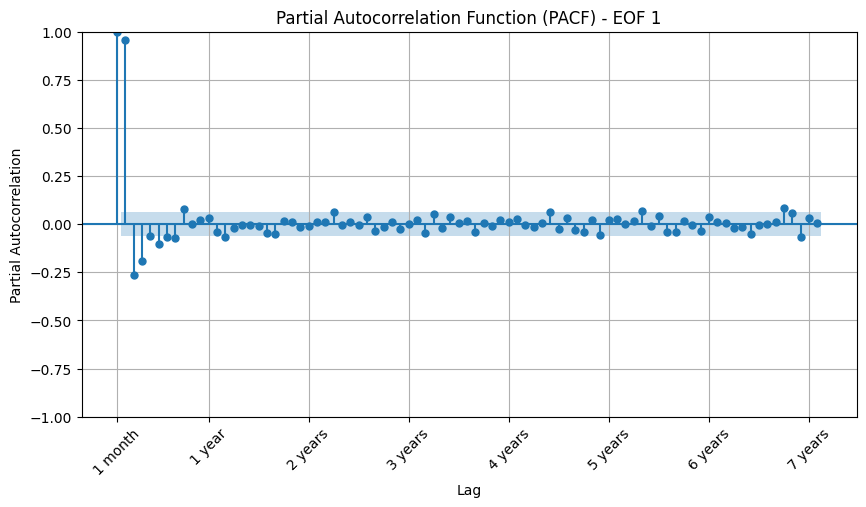

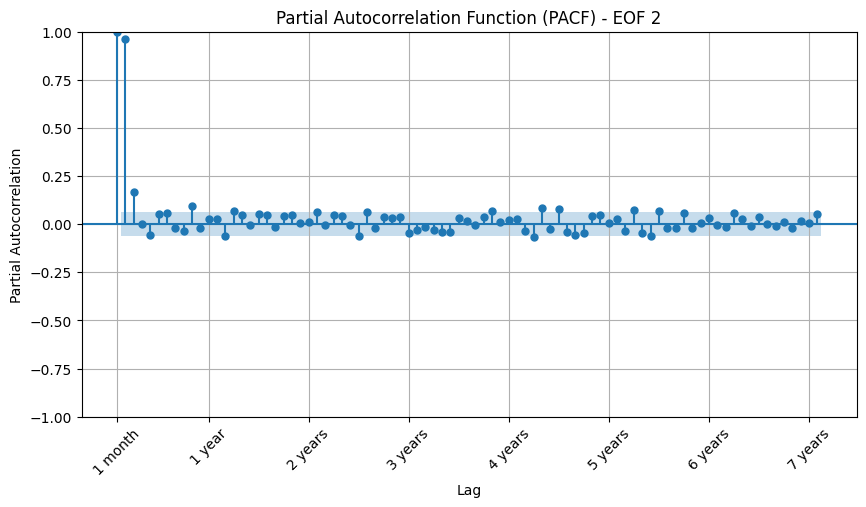

In [ ]:
# Define x-labels
period = 7 #number of years we are interested to look at PAC
labels = [None]*(period*12)
i = 0
ticks = []
while i<(period*12):
  ticks.append(i)
  if i==0:
    labels[i] = '1 month'
    i=i+11
  else:
    if i==11:
      labels[i] = str(int((i+1)/12)) + ' year'
    else:
      labels[i] = str(int((i+1)/12)) + ' years'
    i=i+12

for i in range(i_max):
    # Compute PACF
    pacf_values, pacf_confint = sm.tsa.pacf(normalized_data[i], nlags=period*12, alpha=0.05)

    # Plot PACF
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_pacf(normalized_data[i], lags=period*12, ax=ax, alpha=0.05)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.title('Partial Autocorrelation Function (PACF) - EOF ' + str(i+1))
    ax.set_xticks(ticks) # x-labels for defined values
    ax.set_xticklabels([labels[idx] for idx in ticks], rotation=45)
    plt.grid(True)
    plt.show()

3.4. **Seasonal decomposition**

First we used Seasonal.decompose (the trend is the result of a convolution, using linear least-squares extrapolation for both ends). We then subtract it from the original series to look at anomalies.

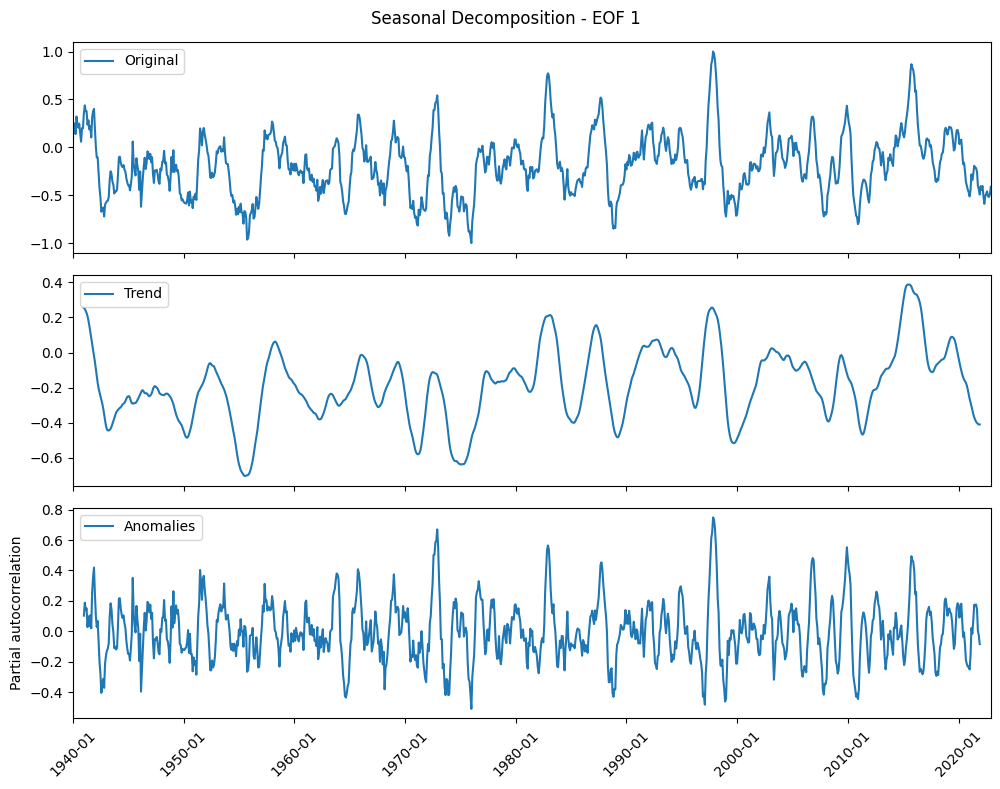

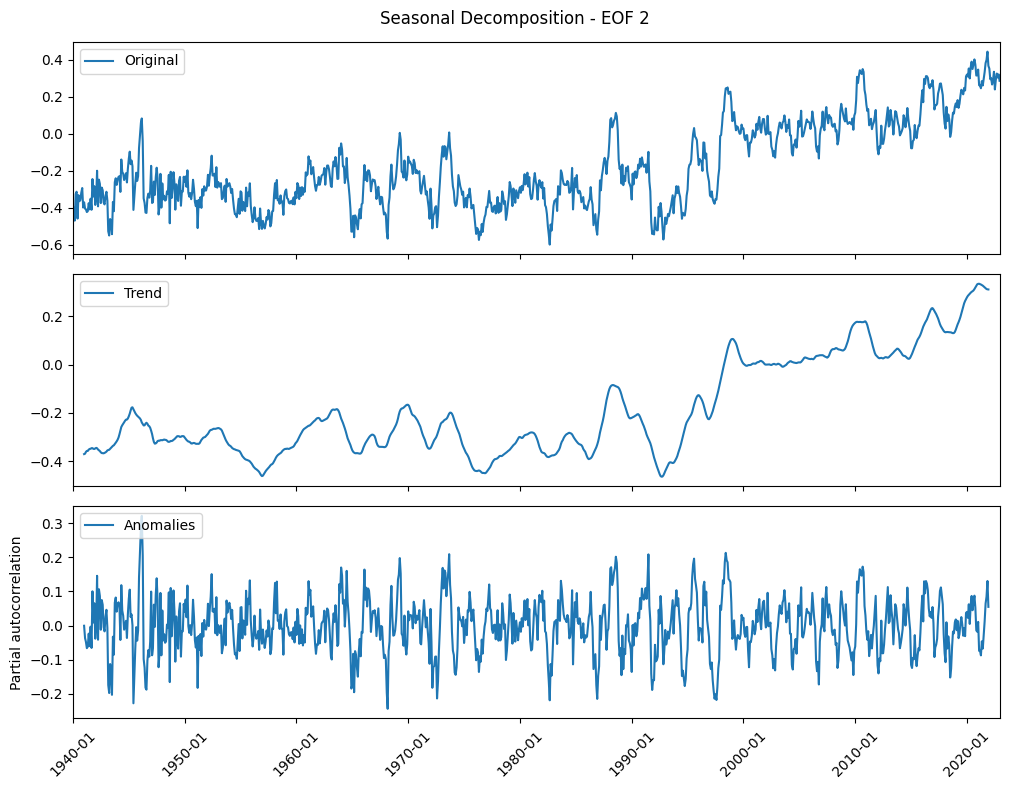

In [ ]:
for i in range(i_max):
    series_i = normalized_data[i]
    series_i = pd.Series(series_i, index=date_index) # convert the series in a pandas object with coinciding data_index
    decomposition = seasonal_decompose(series_i, model='additive',period=24)
    #compute anomalies
    anomalies_i = series_i - decomposition.trend

    # Plot decomposition
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    axes[0].plot(series_i, label='Original')
    axes[0].legend(loc='upper left')
    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].legend(loc='upper left')
    axes[2].plot(anomalies_i, label='Anomalies')
    axes[2].legend(loc='upper left')
    axes[2].xaxis.set_major_locator(mdates.YearLocator(10, month=1, day=1))  # 10 year interval, tick at 01/01/year
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[2].set_xlim([date_index[0], date_index[-1]]) # label limit doesn't exceed december


    for ax in axes:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    fig.suptitle('Seasonal Decomposition - EOF ' + str(i+1))
    plt.tight_layout()
    plt.ylabel('Partial autocorrelation')
    plt.show()

    # # PLOT ONLY ANOMALIES TO COMPARE WITH ENSO INDEX
    # anomalies_i_1979 = anomalies_i[anomalies_i.index >= pd.Timestamp('1979-01-01')]
    # # Plot
    # fig, axes = plt.subplots(figsize=(10, 8))
    # plt.plot(anomalies_i_1979.index, anomalies_i_1979, label='Anomalies')
    # plt.xlabel('Time')
    # plt.xticks(rotation=45)  # Rotate labels
    # plt.title('Anomalies - EOF ' + str(i+1))
    # plt.grid(True)
    # plt.tight_layout()  # Automatic regulation to avoid superpositioning
    # plt.xlim(pd.Timestamp('1979-01-01'), anomalies_i_1979.index[-1])
    # plt.show()

3.5. Secondly we compute the **linear trend** to study stationarity. Ipothesis test on the stationariety of the series. An **Augmented Dickey-Fuller test** is used, if p-value < 0.05, we can refuse the null hypothesis and conclude that the series is stationary.

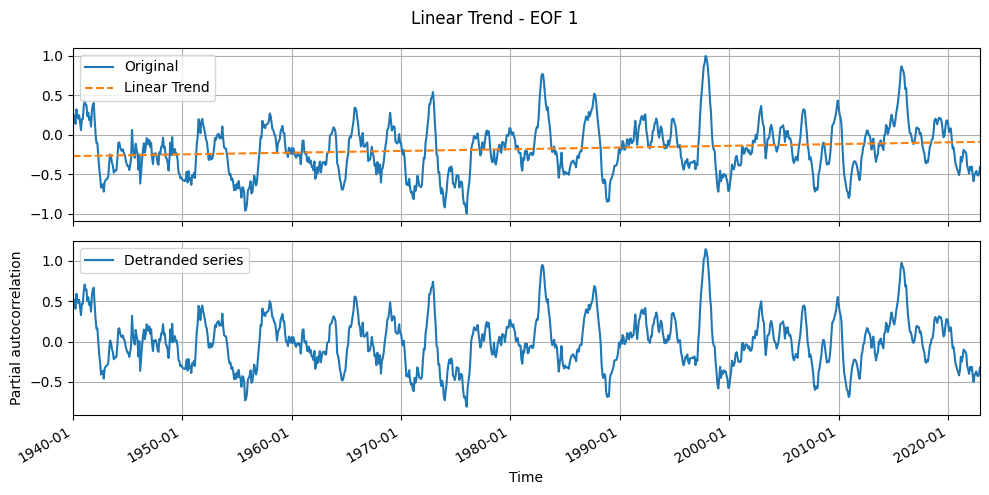

Test Statistic: -7.926265502385095
p-value: 3.611868498182969e-12
Critical Values:
	1%: -3.4369860032923145
	5%: -2.8644697838498376
	10%: -2.5683299626694422

Test result:
The series is stationary with 5% of significance level.


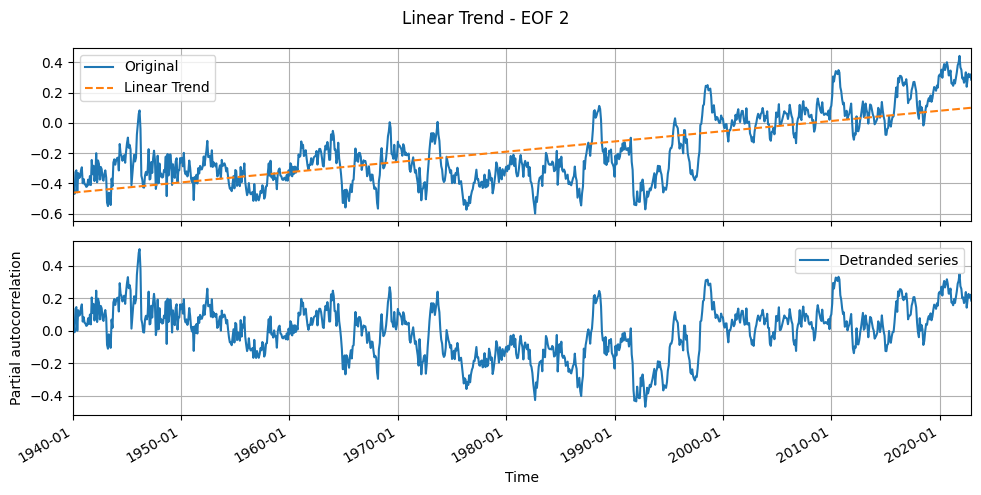

Test Statistic: -4.251791804557162
p-value: 0.0005378028883739458
Critical Values:
	1%: -3.4370266558635914
	5%: -2.864487711945291
	10%: -2.5683395116993872

Test result:
The series is stationary with 5% of significance level.


In [ ]:
detrended_list = []
trend_list = []
for i in range(i_max):
    series_i = normalized_data[i]
    time_index = np.arange(len(series_i))#.reshape(-1, 1) #array con indici temporali 1-996 in collona (reshape)

    # Compute the linear trend
    m, b = np.polyfit(time_index, series_i, 1)
    trend = m * time_index + b
    detrended_series = series_i - trend

    detrended_list.append(detrended_series)
    trend_list.append(trend)

    # Plot original series and trend
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    fig.suptitle('Linear Trend - EOF ' + str(i+1))
    axes[0].plot(date_index, series_i, label='Original')
    axes[0].plot(date_index, trend, label='Linear Trend', linestyle='--')
    axes[0].legend(loc='upper left')
    axes[0].grid(True)
    axes[1].plot(date_index, detrended_series, label='Detranded series')
    axes[1].legend(loc='upper left')
    axes[1].grid(True)
    axes[1].xaxis.set_major_locator(mdates.YearLocator(10, month=1, day=1)) # 10 year interval x-ticks, tick at 01/01/year
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[1].set_xlim([date_index[0], date_index[-1]])
    plt.gcf().autofmt_xdate()
    plt.xlabel('Time')
    plt.ylabel('Partial autocorrelation')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Hypothesis test
    result = adfuller(detrended_series)

    print('Test Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('')

    # Result interpretation
    print('Test result:')
    if result[1] < 0.05:
        print("The series is stationary with 5% of significance level.")
    else:
        print("The series is not stationary with 5% of significance level.")


# *BLOCK 4. LSTM model*

4.1. Define the LSTM model, training and evaluation.

In [ ]:
# Define dimensions of training, validation and test set
def split_data(series_i, train_percentage, val_percentage):
    train_size = int(len(series_i) * train_percentage)
    val_size = int(len(series_i) * val_percentage)
    test_size = len(series_i) - train_size - val_size

    train_data = series_i[:train_size]
    val_data = series_i[train_size:train_size + val_size]
    test_data = series_i[train_size + val_size:]
    return train_data, val_data, test_data

# Function for the moving window
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Conversion in PyTorch tensors
def to_tensor(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    return X_tensor, y_tensor

# DataLoader to shuffle data
def create_dataloader(X, y, batch_size, shuffle=False):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Define the model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Define training
def train_model(model, train_loader, val_loader, optimizer, loss_function, epochs, patience):

    global best_val_loss, early_stopping_counter
    best_val_loss = float('inf')
    early_stopping_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        for seq, labels in train_loader:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                                 torch.zeros(1, 1, model.hidden_size))
            seq = seq.view(-1, 1, input_size)
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
            batch_train_losses.append(single_loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for seq, labels in val_loader:
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                                     torch.zeros(1, 1, model.hidden_size))
                seq = seq.view(-1, 1, input_size)
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                batch_val_losses.append(single_loss.item())

        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch} Val Loss: {val_loss}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Function to make predictions for the whole series
def predict_whole_series(model, series, seq_length):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(series) - seq_length):
            seq = series[i:i + seq_length]
            seq = torch.tensor(seq, dtype=torch.float32).view(-1, 1, input_size)
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                                 torch.zeros(1, 1, model.hidden_size))
            y_pred = model(seq)
            predictions.append(y_pred.item())
    return predictions

# Definition of evaluation metrics
def evaluate_model(model, data_loader, loss_function, trend):
    model.eval()
    losses = []
    y_true = []
    y_pred = []
    with torch.no_grad():
        for seq, labels in data_loader:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                                 torch.zeros(1, 1, model.hidden_size))
            seq = seq.view(-1, 1, input_size)
            predictions = model(seq)
            loss = loss_function(predictions, labels)
            losses.append(loss.item())
            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    mse = np.mean(losses)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
    r2 = 1 - (np.sum((np.array(y_true) - np.array(y_pred)) ** 2) / np.sum((np.array(y_true) - np.mean(np.array(y_true))) ** 2))
    correlation = np.corrcoef((np.array(y_pred)).squeeze(), (np.array(y_true)).squeeze())[0,1]

    return mse, rmse, mae, r2, correlation, y_true, y_pred

4.2. Parameters of the model.

In [ ]:
# Parameters
input_size = 1
hidden_size = 64
output_size = 1
seq_length = 12  # Length of temporal sequence for moving window
train_percentage = 0.8
val_percentage = 0.1
epochs = 100
batch_size = 1
patience = 10 # early stopping patience

4.3. Run the model on the series.

Epoch 0 Val Loss: 0.017788242387619047
Epoch 10 Val Loss: 0.006938591049273045
Early stopping at epoch 14


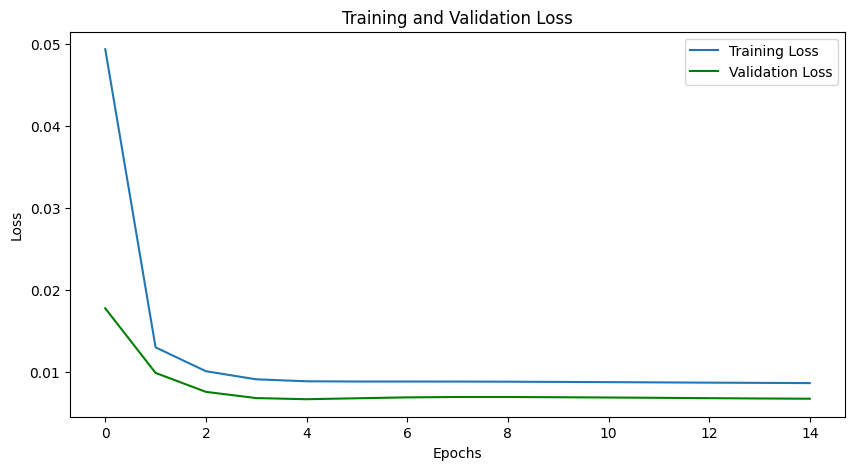

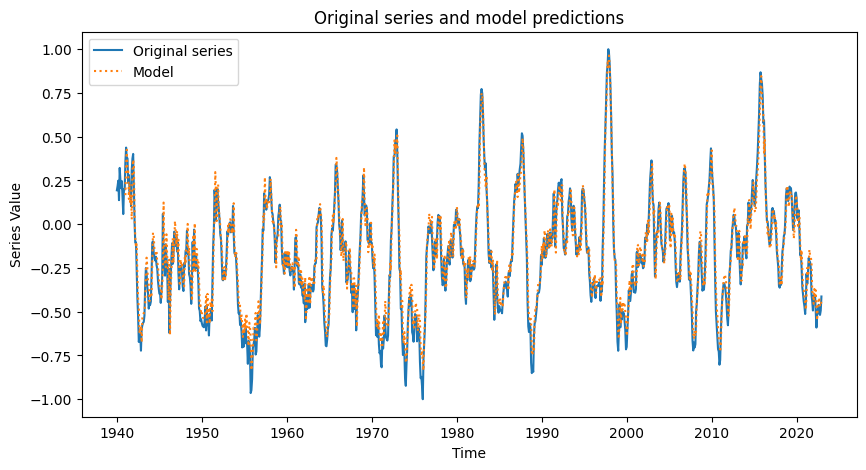

Test MSE: 0.004985020743917498
Test RMSE: 0.07060467933442865
Test MAE: 0.05782483145594597
Test R^2: 0.957911740988493
Test correlation: 0.9808826038612064


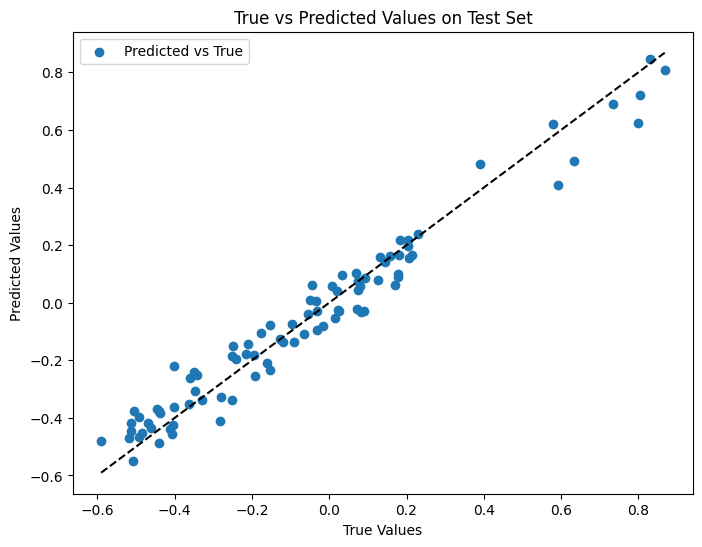

Epoch 0 Val Loss: 0.008643336766791153
Epoch 10 Val Loss: 0.002337100752875555
Epoch 20 Val Loss: 0.0022510401552500066
Epoch 30 Val Loss: 0.0026345829287700204
Early stopping at epoch 30


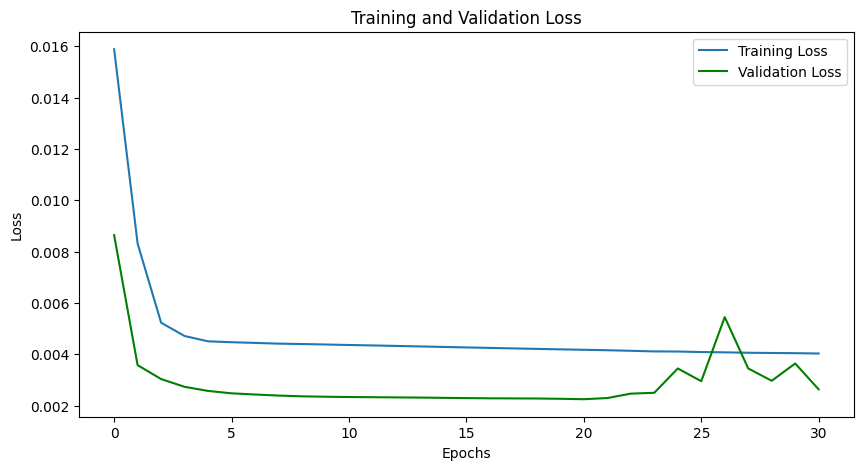

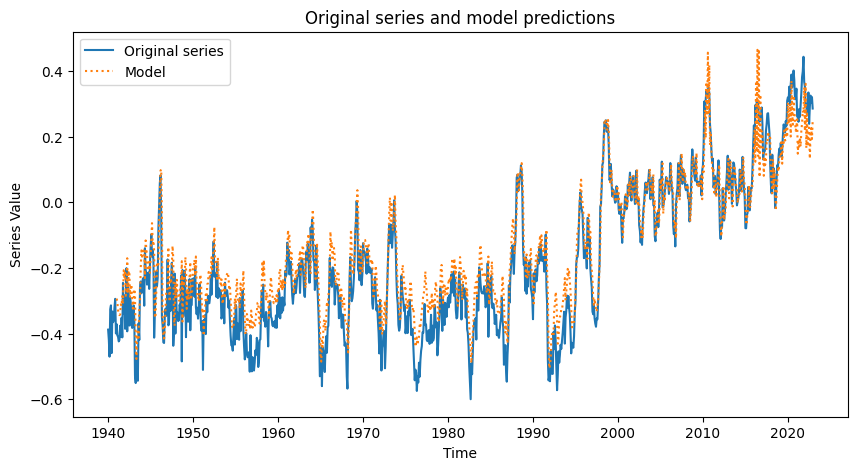

Test MSE: 0.007688959118000019
Test RMSE: 0.08768671004205836
Test MAE: 0.07237249612808228
Test R^2: 0.2839732766151428
Test correlation: 0.7381939133758567


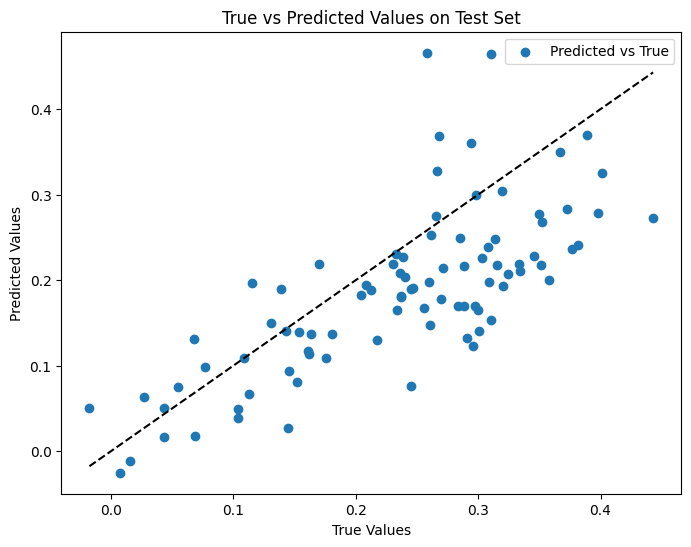

In [ ]:
for i in range(i_max):
  # Assume normalized_data is already provided
  series_i = normalized_data[i]
  #series_i = detrended_list[i]

  # Initialise data
  train_data, val_data, test_data = split_data(series_i, train_percentage, val_percentage)

  X_train, y_train = create_sequences(train_data, seq_length)
  X_val, y_val = create_sequences(val_data, seq_length)
  X_test, y_test = create_sequences(test_data, seq_length)

  X_train, y_train = to_tensor(X_train, y_train)
  X_val, y_val = to_tensor(X_val, y_val)
  X_test, y_test = to_tensor(X_test, y_test)

  train_loader = create_dataloader(X_train, y_train, batch_size)
  val_loader = create_dataloader(X_val, y_val, batch_size)
  test_loader = create_dataloader(X_test, y_test, batch_size, shuffle=False)

  # Initialise the model
  model = LSTMModel(input_size, hidden_size, output_size)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # Initialise training
  train_model(model, train_loader, val_loader, optimizer, loss_function, epochs, patience)

  # Make predictions for the whole series
  predictions = predict_whole_series(model, series_i, seq_length)

  # Plot the original series and the predicted series
  plt.figure(figsize=(10, 5))
  plt.plot(date_index, series_i, label='Original series')
  # Adding NaNs at the beginning of the predictions for alignment
  predictions = [np.nan] * seq_length + predictions
  plt.plot(date_index, predictions, label='Model', linestyle='dotted')
  plt.xlabel('Time')
  plt.ylabel('Series Value')
  plt.title('Original series and model predictions')
  plt.legend()
  plt.show()

  # Model final evaluation on the test set
  mse, rmse, mae, r2, correlation, y_true, y_pred = evaluate_model(model, test_loader, loss_function, trend_list[i])
  print(f'Test MSE: {mse}')
  print(f'Test RMSE: {rmse}')
  print(f'Test MAE: {mae}')
  print(f'Test R^2: {r2}')
  print(f'Test correlation: {correlation}')

  # Scatter plot for true vs predicted values on test set
  plt.figure(figsize=(8, 6))
  plt.scatter(y_true, y_pred, label='Predicted vs True')
  plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--')
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title('True vs Predicted Values on Test Set')
  plt.legend()
  plt.show()

4.4. Run the model on detrended series.

Epoch 0 Val Loss: 0.004051300323104624
Epoch 10 Val Loss: 0.0026717513417760194
Early stopping at epoch 15


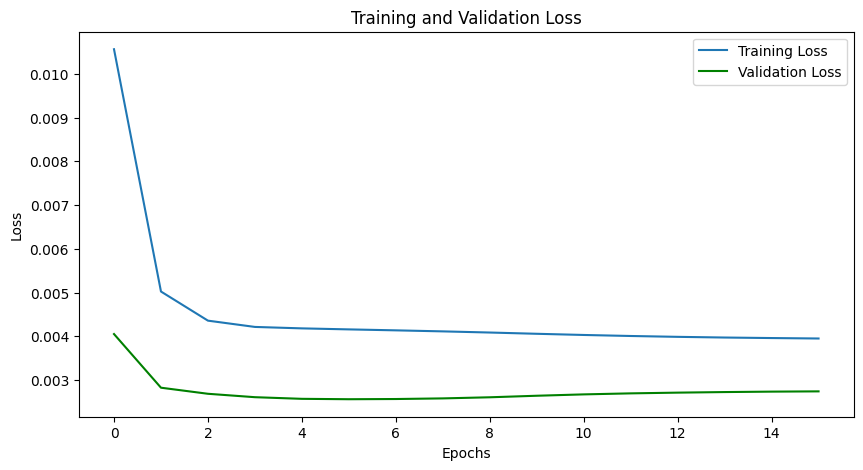

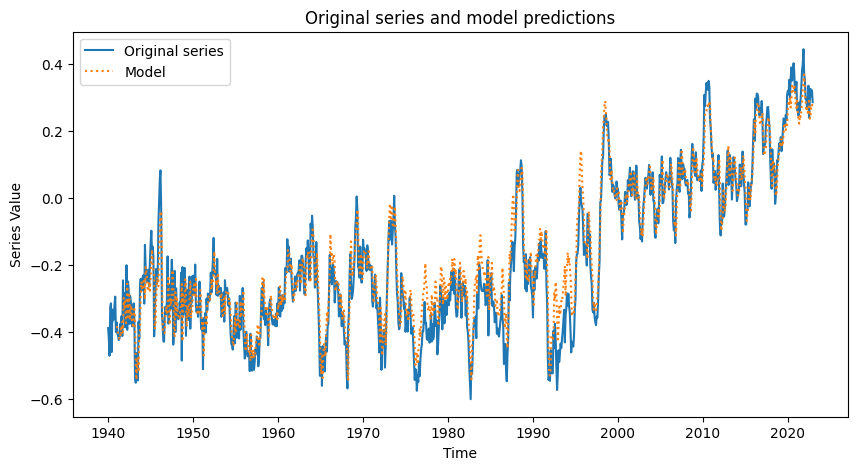

Test MSE: 0.002496789232275799
Test RMSE: 0.049967882007103316
Test MAE: 0.04069002717733383
Test R^2: 0.7315784692764282
Test correlation: 0.8948028804742807


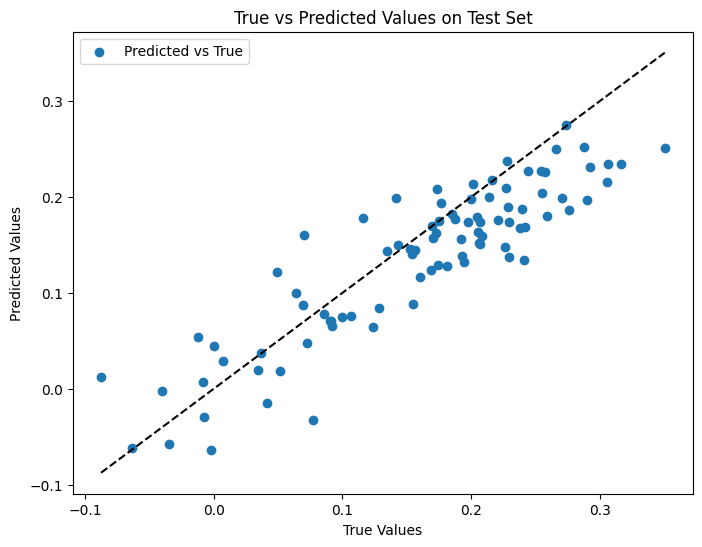

In [ ]:
i=1
# Assume normalized_data is already provided
series_i = detrended_list[i]

# Initialise data
train_data, val_data, test_data = split_data(series_i, train_percentage, val_percentage)

X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train, y_train = to_tensor(X_train, y_train)
X_val, y_val = to_tensor(X_val, y_val)
X_test, y_test = to_tensor(X_test, y_test)

train_loader = create_dataloader(X_train, y_train, batch_size)
val_loader = create_dataloader(X_val, y_val, batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size, shuffle=False)

# Initialise the model
model = LSTMModel(input_size, hidden_size, output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialise training
train_model(model, train_loader, val_loader, optimizer, loss_function, epochs, patience)

# Make predictions for the whole series
predictions = predict_whole_series(model, series_i, seq_length)

# Plot the original series and the predicted series
plt.figure(figsize=(10, 5))
plt.plot(date_index, normalized_data[i], label='Original series')
# Adding NaNs at the beginning of the predictions for alignment
predictions = [np.nan] * seq_length + predictions +trend_list[i]
plt.plot(date_index, predictions, label='Model', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.title('Original series and model predictions')
plt.legend()
plt.show()

# Model final evaluation on the test set
mse, rmse, mae, r2, correlation, y_true, y_pred = evaluate_model(model, test_loader, loss_function, trend_list[i])
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test R^2: {r2}')
print(f'Test correlation: {correlation}')

# Scatter plot for true vs predicted values on test set
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, label='Predicted vs True')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values on Test Set')
plt.legend()
plt.show()

# *BLOCK 5. Forecast*

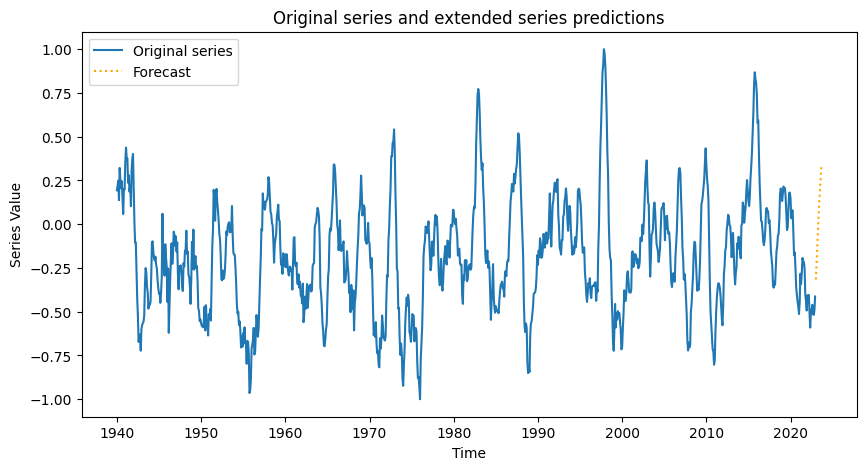

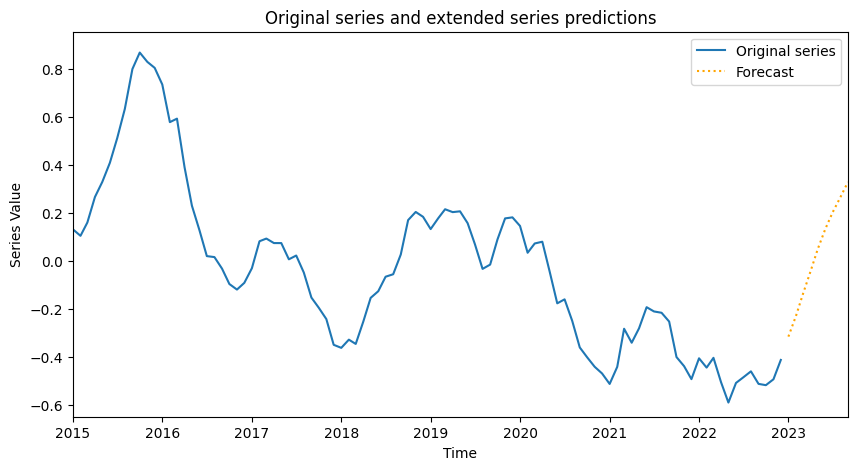

In [ ]:
series_i = normalized_data[0]

# Define forecasting
def extend_series(model, series, seq_length, n_months):
    model.eval()
    extended_series = list(series)  # Copy original series
    current_sequence = series[-(seq_length):]  # Start from last temporal window
    with torch.no_grad():
        for _ in range(n_months):
            seq = torch.tensor(current_sequence, dtype=torch.float32).view(-1, 1, input_size)
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                                 torch.zeros(1, 1, model.hidden_size))
            y_pred = model(seq)
            extended_series.append(y_pred.item()) #Add prediction to finale series
            current_sequence = extended_series[-seq_length:]  # Refresh moving window

    return extended_series

# Compute forecast
forecast_len = 9 #number of month of forecast
extended_series = extend_series(model, series_i, seq_length, forecast_len)

# Extend date index list
date_index_extended = pd.date_range(start=start_time, periods=(996+forecast_len), freq='MS')  # 'MS' beggining of the month

# Plot original series and following forecast
plt.figure(figsize=(10, 5))
plt.plot(date_index, series_i, label='Original series')
plt.plot(date_index_extended[len(series_i):], extended_series[len(series_i):], label='Forecast', linestyle='dotted', color='orange')
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.title('Original series and extended series predictions')
plt.legend()
plt.show()
# Zoom in the last portion of the series
plt.figure(figsize=(10, 5))
plt.plot(date_index, series_i, label='Original series')
plt.plot(date_index_extended[len(series_i):], extended_series[len(series_i):], label='Forecast', linestyle='dotted', color='orange')
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.title('Original series and extended series predictions')
plt.legend()
plt.xlim(date_index_extended[900], date_index_extended[-1])
plt.ylim(min(series_i[900:])*1.1, max(extended_series[900:]) * 1.1)
plt.show()